In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
source = 'Stock_DATA'
name1 = 'energy' 
name2 = 'shipping'
p_H = pd.read_excel(source+'/'+name1+'.xlsx')
p_E = pd.read_excel(source+'/'+name2+'.xlsx')

In [34]:
def generate_data(port):
    r = 0.0002
    ### สร้าง Return Rate ###
    port = port.iloc[-25:]
    K = port.drop('Date', axis=1).pct_change().dropna()
    (n, m) = K.shape
    
    ### ส่วนประกอบคำนวณ ###
    muk = K.mean().values.reshape((m,1)) # Matrix [10x1]
    u = np.ones((m, 1))                  # Matrix [10x1]

    Ck = K.cov().to_numpy() # Sqaure Matrix [10x10]
    iCk = np.linalg.inv(Ck) # Sqaure Matrix [10x10]

    uiCm = np.dot(np.dot(u.transpose(),iCk),muk)    # [1x10][10x10][10x1] = [1x1]
    miCm = np.dot(np.dot(muk.transpose(),iCk),muk)  # [1x10][10x10][10x1] = [1x1]
    uiCu = np.dot(np.dot(u.transpose(),iCk),u)      # [1x10][10x10][10x1] = [1x1]

    wm = np.dot(iCk,np.divide(muk-r*u,uiCm-r*uiCu))          # Matrix [10x1]
    mu_mk = np.dot(muk.transpose(),wm)                       # Matrix [10x1]
    sigma_mk = np.sqrt(np.dot(wm.transpose(),np.dot(Ck,wm))) # Matrix [1x1]
    
    ### สร้างเส้น CML & SML ###
    muvk = np.arange(-0.02,0.025,0.00001)
    muvk = muvk.reshape((len(muvk),1))
    bb = np.divide(muvk-r,mu_mk-r)
    sigmavk1 = [0]*len(muvk)
    for i in range(0,len(muvk)):
        w = np.divide(np.dot(np.dot(muvk[i][0]-r,iCk),muk)-np.dot(np.dot(r*(muvk[i][0]-r),iCk),u),(miCm-r*uiCm)-r*(uiCm-r*uiCu))
        sigmavk1[i] = np.sqrt(np.dot(np.dot(w.transpose(),Ck),w))[0]
        
    return n, m, K, wm, muk, mu_mk, sigma_mk, muvk, bb, sigmavk1

In [35]:
def create_beta_sigma_dot(i, K, wm, Km):
    ### สร้างจุดหุ้นบน Plot ###
    #Km = np.dot(K,wm).transpose()
    Kv = K.iloc[:,i].to_numpy()
    stk_name = K.iloc[:,i].name
    CC = np.cov([Km[0],Kv])
    mu_v = K.iloc[:,i].mean()
    sigma_v = np.sqrt(CC[1][1])
    beta_v = CC[1][0]/CC[0][0]
    return sigma_v, beta_v, mu_v, stk_name

In [36]:
def plot_beta_sigma(df, sigma_line, beta_line, muvk_line):
    fig, axs = plt.subplots(1, 2,figsize=(17,6))
    axs[0].set_title('Capital Market Line')
    axs[1].set_title('Security Market Line')
    sns.scatterplot(ax=axs[0],x='sigmav', y='muv',  data=df, hue="stockGroup")
    sns.scatterplot(ax=axs[1],x='betav', y='muv',  data=df, hue="stockGroup")
    for e in range(0, len(df['stockName'])):
        axs[0].text(df['sigmav'][e]+0.001,df['muv'][e], df['stockName'][e], fontsize=10)
        axs[1].text(df['betav'][e]+0.02,df['muv'][e], df['stockName'][e], fontsize=10)
    axs[0].grid(True, which='both')
    axs[1].grid(True, which='both')
    sns.despine(ax=axs[0], offset=0)
    sns.despine(ax=axs[1], offset=0)
    axs[0].plot(sigma_line, muvk_line,'k',linewidth=1)
    axs[1].plot(beta_line, muvk_line,'k:',linewidth=1)
    axs[1].set_xlim([-0.5,2])

แยกอุตสาหกรรม

In [37]:
n_h, m_h, K_h, wm_h, muk_h, mu_mk_h, sigma_mk_h, muvk_h, bb_h, sigmavk_h = generate_data(p_H)
n_e, m_e, K_e, wm_e, muk_e, mu_mk_e, sigma_mk_e, muvk_e, bb_e, sigmavk_e = generate_data(p_E)

In [38]:
sigmav_h, betav_h, muv_h, stockName_h, stockGroup_h = [0]*m_h,[0]*m_h,[0]*m_h,[0]*m_h,[name1]*m_h
Km = np.dot(K_h,wm_h).transpose()
for each in range(0, m_h):
    sigmav_h[each], betav_h[each], muv_h[each], stockName_h[each] = create_beta_sigma_dot(each, K_h, wm_h, Km)

In [39]:
sigmav_e, betav_e, muv_e, stockName_e, stockGroup_e = [0]*m_e,[0]*m_e,[0]*m_e,[0]*m_e,[name2]*m_e
for each in range(0, m_e):
    sigmav_e[each], betav_e[each], muv_e[each], stockName_e[each] = create_beta_sigma_dot(each, K_e, wm_e, Km)

In [40]:
sigmav = sigmav_h + sigmav_e
betav = betav_h + betav_e
muv = muv_h + muv_e
stockName = stockName_h + stockName_e
stockGroup = stockGroup_h + stockGroup_e
df = pd.DataFrame([sigmav, betav, muv, stockName, stockGroup]).T
df.columns = ['sigmav','betav','muv','stockName','stockGroup']

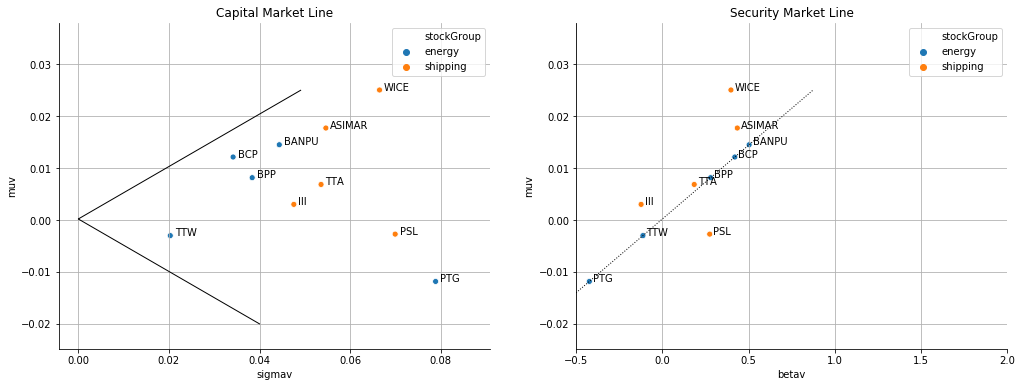

In [41]:
plot_beta_sigma(df, sigmavk_h, bb_h, muvk_h)